In [1]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

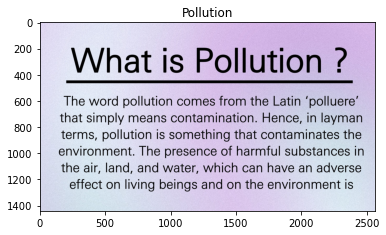

In [2]:
image = cv2.imread('Pollution.jpg')
b,g,r = cv2.split(image) # blue, green, red
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('Pollution')
plt.show()

### BINARISATION

In [3]:
# This is for converting an image to black and white. Tesseract does this internally (Otsu algorithm), 
# but the result can be suboptimal, particularly if the page background is of uneven darkness.

def thresholding(image):
#     [a,b] = cv2.threshold(p1, p2, p3, p4)
    
#     p1 = source image which should be grayscale image
#     p2 = threshold value which is used to classify the pixel values
#     p3 = maximum value which is assigned to pixel values exceeding the threshold
#     p4 = type of thresholding like : cv.THRESH_BINARY, cv.THRESH_BINARY_INV, cv.THRESH_TRUNC, cv.THRESH_TOZERO etc

#     a = threshold that was used
#     b = thresholded image
    
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [4]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
gray = get_grayscale(image)
thresh = thresholding(gray)

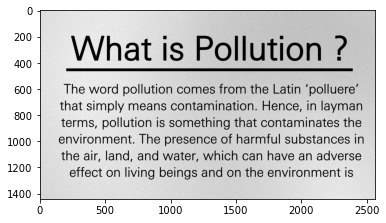

In [6]:
plt.imshow(gray, cmap = 'gray')

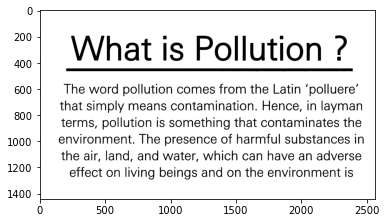

In [7]:
plt.imshow(thresh, cmap = 'gray')

### DILATION AND EROSION


In [8]:
# Bold characters or Thin characters may impact the recognition of details and reduce recognition
# accuracy. Many image processing programs allow Dilation and Erosion of edges of characters against a common background to
# dilate or grow in size (Dilation) or shrink (Erosion).

# Heavy ink bleeding from historical documents can be compensated for by using an Erosion technique. Erosion can be used to 
# shrink characters back to their normal structure.

# dilating the image to add pixels to the boundaries of objects in an image
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#     cv2.dilate(p1, p2, p3), cv2.erode(p1, p2, p3)

#     p1 = original image
#     p2 = matrix with which image is convolved
#     p3 = number of iterations, which will determine how much you want to erode/dilate a given image
    
    
# erosion to remove pixels on object boundaries
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

In [9]:
dilated_image = dilate(image)

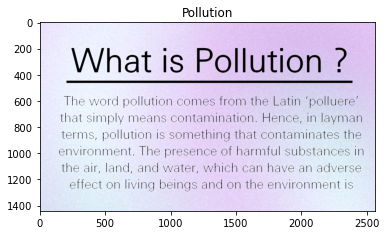

In [10]:
b,g,r = cv2.split(dilated_image) # blue, green, red
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('Pollution')
plt.show()

In [11]:
eroded_image = erode(image)

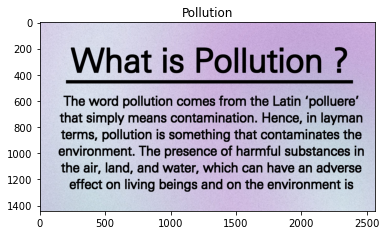

In [12]:
b,g,r = cv2.split(eroded_image) # blue, green, red
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('Pollution')
plt.show()

### Rotation / Deskewing

In [13]:
# A skewed image is when a page has been scanned when not straight. The quality of Tesseract’s line segmentation reduces
# significantly if a page is too skewed, which severely impacts the quality of the OCR. To address this, rotate the page 
# image so that the text lines are horizontal.


#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    
#    for finding the minimum area rotated rectangle
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
#    used to make the transformation matrix M which will be used for rotating a image

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
#     center: Center of rotation
#     angle(θ): Angle of Rotation. Angle is positive for anti-clockwise and negative for clockwise.
#     1.0: scaling factor which scales the image


    
#    applies an affine transformation to an image.Basically, In Affine transformation, all parallel lines in the original
#    image will still be parallel in the output image


#     cv2.warpAffine(src, M, dsize, dst, flags, borderMode, borderValue)
    
#     src: input image.
#     dst: output image that has the size dsize and the same type as src.
#     M: transformation matrix.
#     dsize: size of the output image.
#     flags: combination of interpolation methods and the optional flag
#            WARP_INVERSE_MAP that means that M is the inverse transformation (dst->src).
#     borderMode: pixel extrapolation method; when borderMode=BORDER_TRANSPARENT, it means that the pixels in the destination image corresponding to the “outliers” in the source image are not modified by the function.
#     borderValue: value used in case of a constant border; by default, it is 0.
    
    
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE) 
    return rotated

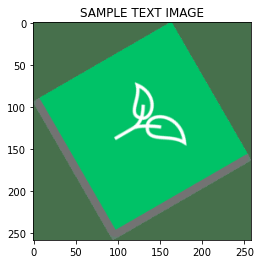

In [14]:
image = cv2.imread('rotated.png')
b,g,r = cv2.split(image) # blue, green, red
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('SAMPLE TEXT IMAGE')
plt.show()

In [ ]:
rotated = deskew(image)

b,g,r = cv2.split(rotated) # blue, green, red
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('SAMPLE TEXT IMAGE')
plt.show()

In [15]:
# noise removal
def remove_noise(image):
    # the central element of the image is replaced by the median of all the pixels in the kernel area. Here 5 is 
    # basically size of kernel
    return cv2.medianBlur(image,5) 

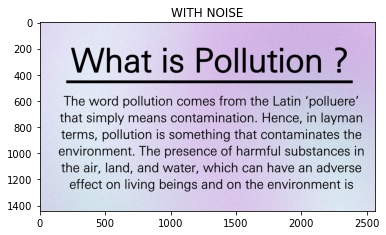

In [16]:
image = cv2.imread('Pollution.jpg')
b,g,r = cv2.split(image) # blue, green, red
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('WITH NOISE')
plt.show()

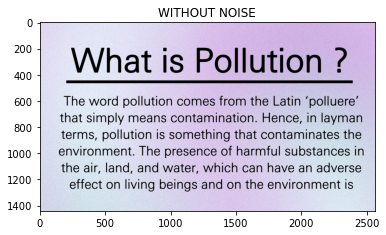

In [17]:
image2 = remove_noise(image)

b,g,r = cv2.split(image2) # blue, green, red
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('WITHOUT NOISE')
plt.show()

In [18]:
# canny edge detection to detect the edges in an image
def canny(image):
    return cv2.Canny(image, 100, 200)

In [19]:
#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

# It simply slides the template image over the input image (as in 2D convolution) and compares the template and patch 
# of input image under the template image"


In [20]:
gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

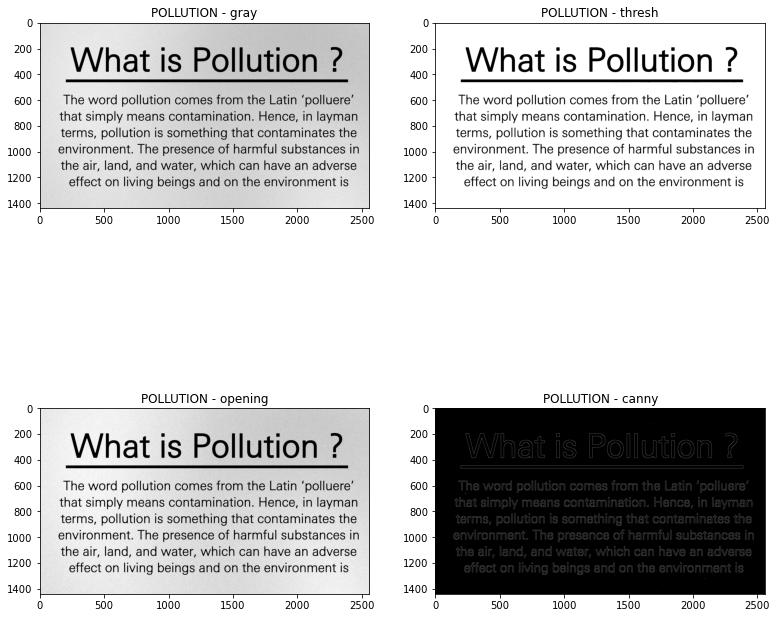

In [21]:
fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('POLLUTION - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')    

In [22]:
custom_config = r'--oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
What is Pollution ?
The word pollution comes from the Latin ‘polluere’
that simply means contamination. Hence, in layman
terms, pollution is something that contaminates the
environment. The presence of harmful substances In
the air, land, and water, which can have an adverse

effect on living beings and on the environment Is


-----------------------------------------
TESSERACT OUTPUT --> THRESHOLDED IMAGE
-----------------------------------------
What is Pollution ?
The word pollution comes from the Latin ‘polluere’
that simply means contamination. Hence, in layman
terms, pollution is something that contaminates the
environment. The presence of harmful substances In
the air, land, and water, which can have an adverse

effect on living beings and on the environment Is


-----------------------------------------
TESSERACT OUTPUT --> OPENED IMAGE
-----------------------

# Bounding box information using Pytesseract

In [23]:
# While running and image through the tesseract OCR engine, pytesseract allows you to get bounding box imformation

# on a character level
# on a word level
# based on a regex template

In [24]:
image = cv2.imread('Pollution_Handwritten.jpg')

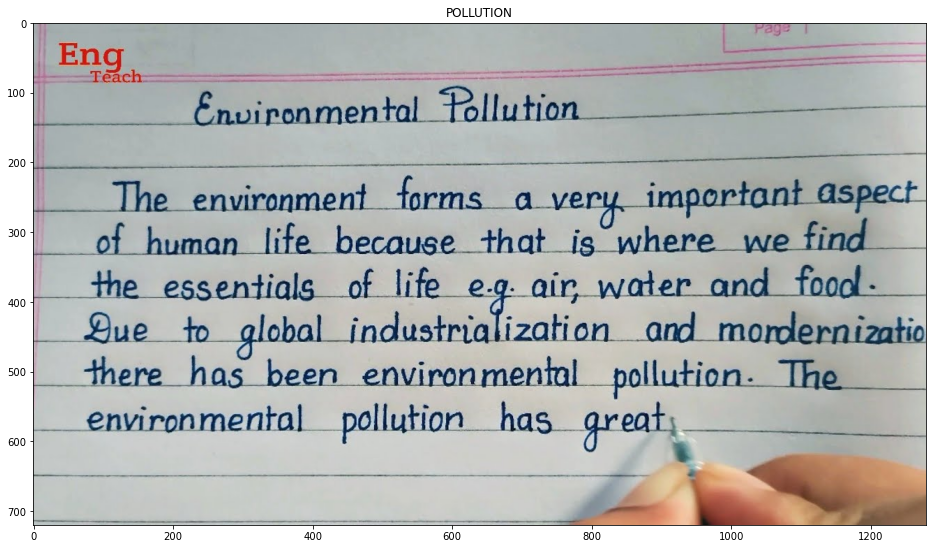

In [25]:
# Plotting original image with increased size

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('POLLUTION')
plt.show()


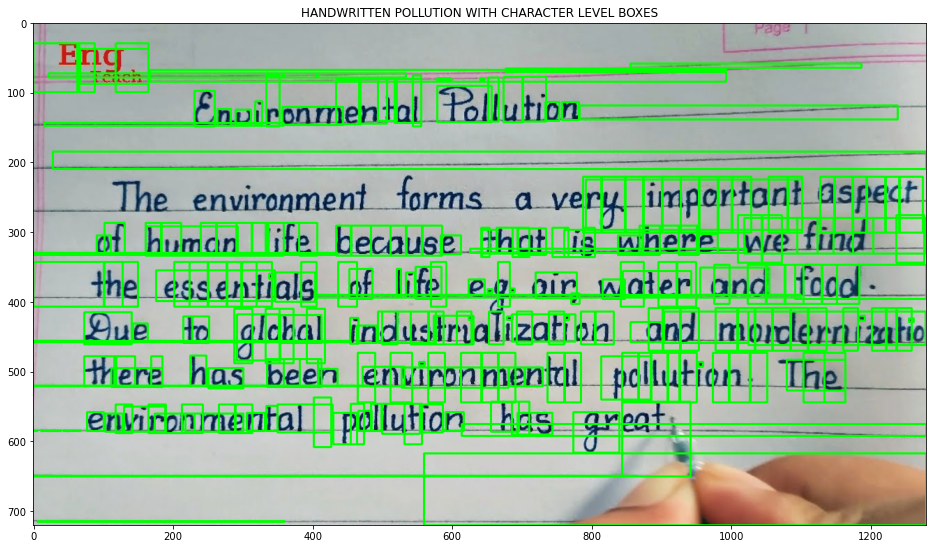

In [26]:
# Bounding box information on a character level


h, w, c = image.shape # shape returns a tuple, h = height, w = width, c = channels

boxes = pytesseract.image_to_boxes(image) # Plot character boxes on image using pytesseract.image_to_boxes() function
i = 0
for b in boxes.splitlines():
#     print(i)
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
#     i += 1

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('HANDWRITTEN POLLUTION WITH CHARACTER LEVEL BOXES')
plt.show()


In [27]:
len(boxes)

5145

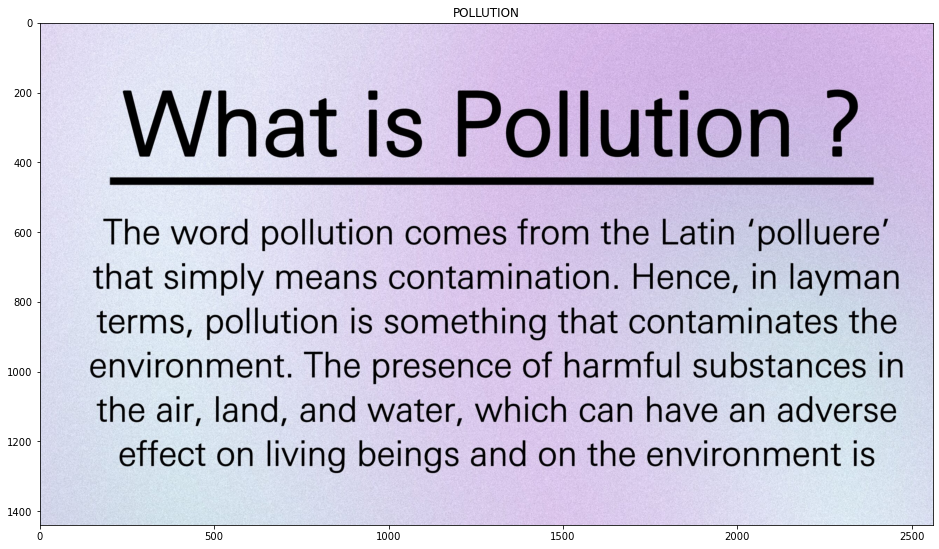

In [28]:
image = cv2.imread('pollution.jpg')

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('POLLUTION')
plt.show()

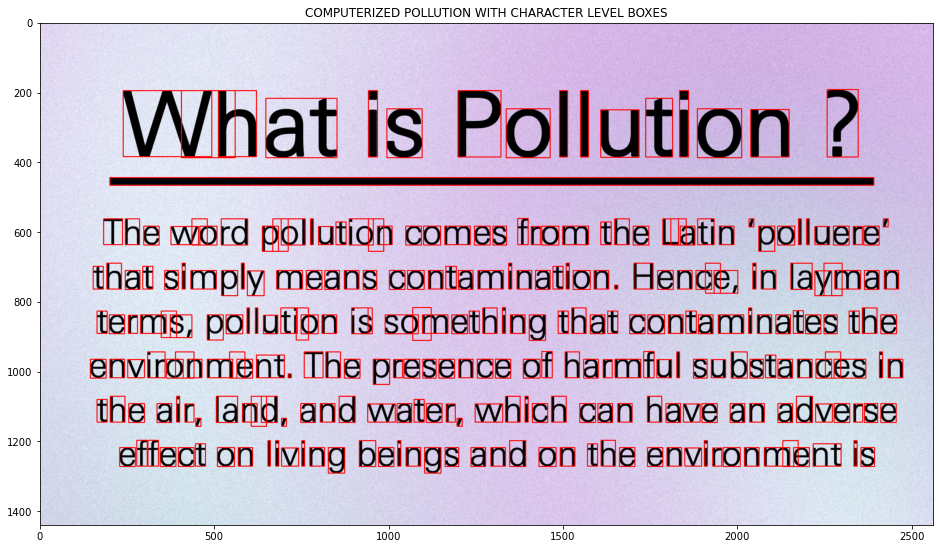

In [29]:
h, w, c = image.shape # shape returns a tuple, h = height, w = width, c = channels

boxes = pytesseract.image_to_boxes(image) # Plot character boxes on image using pytesseract.image_to_boxes() function
i = 0
for b in boxes.splitlines():
#     print(i)
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0,0,255), 2)
#     i += 1

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('COMPUTERIZED POLLUTION WITH CHARACTER LEVEL BOXES')
plt.show()

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


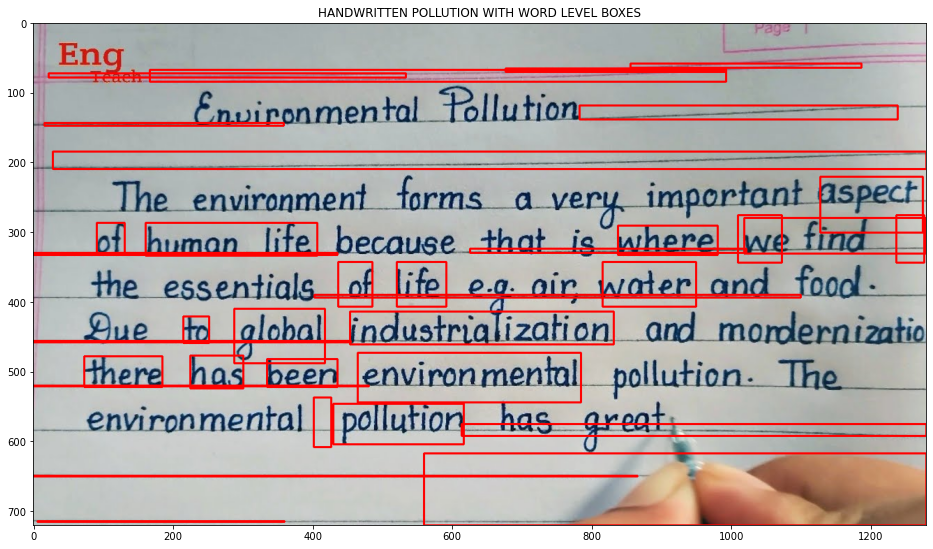

In [30]:
# Bounding Box information on a word level


image = cv2.imread('Pollution_Handwritten.jpg')
d = pytesseract.image_to_data(image, output_type=Output.DICT)
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('HANDWRITTEN POLLUTION WITH WORD LEVEL BOXES')
plt.show()

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


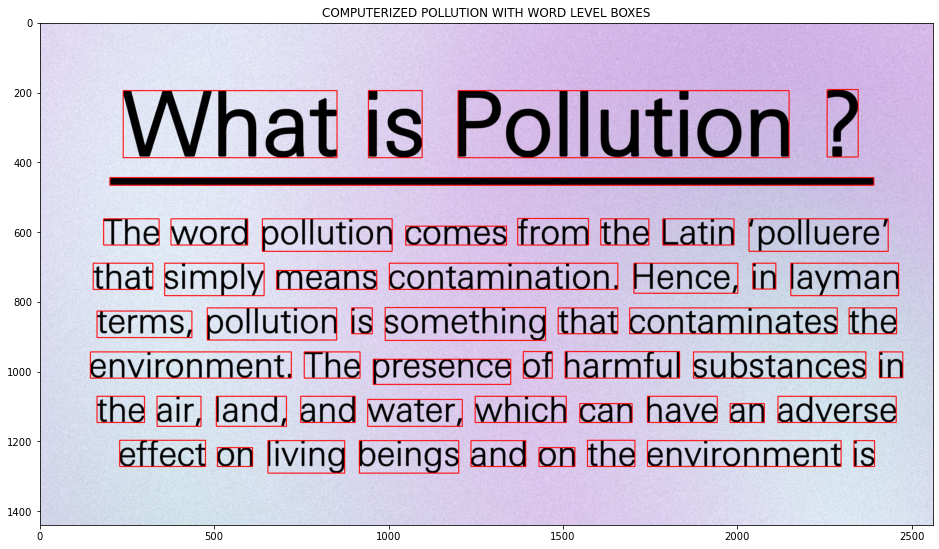

In [31]:
image = cv2.imread('pollution.jpg')
d = pytesseract.image_to_data(image, output_type=Output.DICT)
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('COMPUTERIZED POLLUTION WITH WORD LEVEL BOXES')
plt.show()

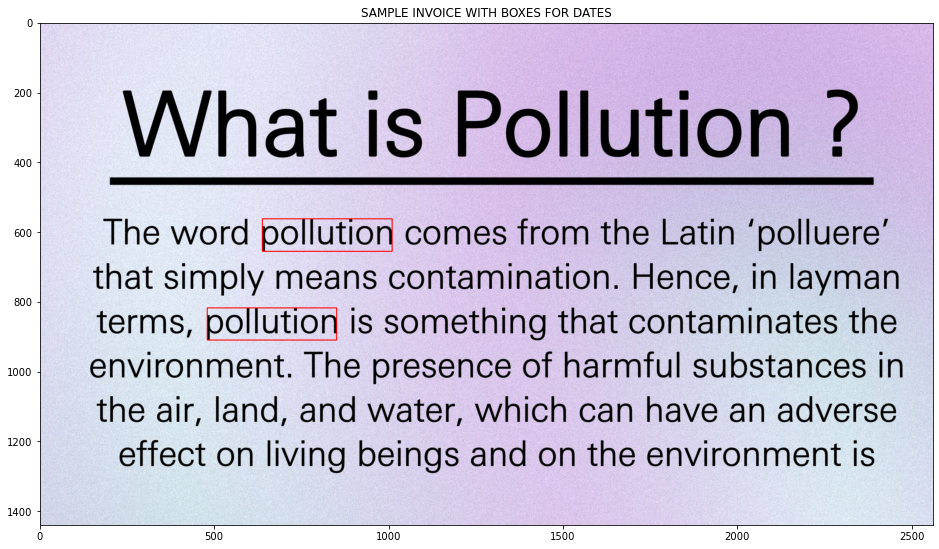

In [32]:
# boxes around a particular word

image = cv2.imread('pollution.jpg')
date_pattern = 'pollution'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH BOXES FOR DATES')
plt.show()


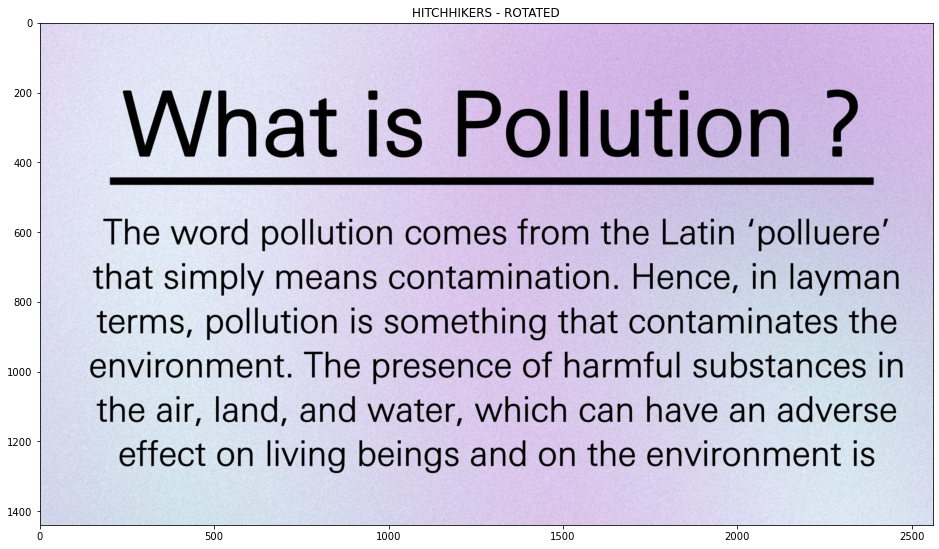

In [33]:
# Detect orientation and script

# We can detect the orientation of text in your image and also the script in which it is written.

image = cv2.imread('pollution.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('HITCHHIKERS - ROTATED')
plt.show()

In [34]:
osd = pytesseract.image_to_osd(image)
angle = re.search('(?<=Rotate: )\d+', osd).group(0)
script = re.search('(?<=Script: )\w+', osd).group(0)
print("angle: ", angle)
print("script: ", script)


angle:  0
script:  Latin


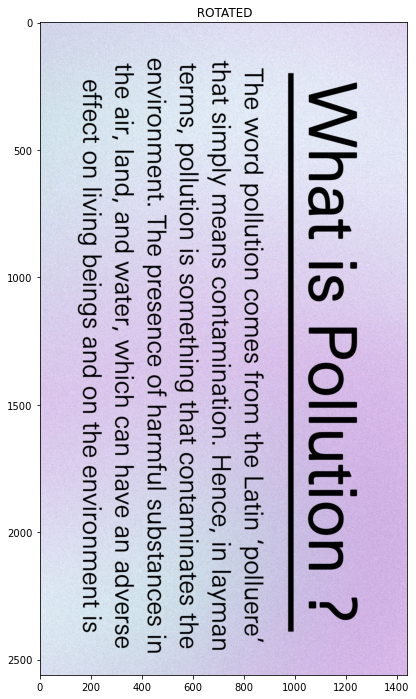

In [36]:
image2 = cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
b,g,r = cv2.split(image2)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title(' ROTATED')
plt.show()

In [16]:
osd = pytesseract.image_to_osd(image2)
angle = re.search('(?<=Rotate: )\d+', osd).group(0)
script = re.search('(?<=Script: )\w+', osd).group(0)
print("angle: ", angle)
print("script: ", script)

angle:  270
script:  Latin


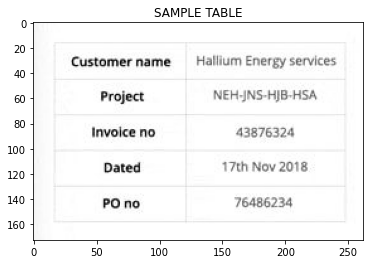

In [37]:
image = cv2.imread('digits-task.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('SAMPLE TABLE')
plt.show()

In [38]:
# Original tesseract output with english language sepcified

custom_config = r'-l eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

‘Customer name —_Halium Energy services
Project NEHINS-HIB-HSA
lavoice no 43876324
Dated 17th Nov2018
Pono 76496234



In [39]:
# Output with outputbase digits

custom_config = r'--oem 3 --psm 6 outputbase digits'
print(pytesseract.image_to_string(image, config=custom_config))

--
. 43876324

172018

0 76496234



In [40]:
# Output with a whitelist of characters (here, we have used all the lowercase characters from a to z only)

custom_config = r'-c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

customernamealiumnergyservices
roject
lavoiceno
ated thov
ono



In [41]:
# Output without the blacklisted characters (here, we have removed all digits)

custom_config = r'-c tessedit_char_blacklist=0123456789 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

‘Customer name —_Halium Energy services
Project NEHINS-HIB-HSA
lavoice no
Dated %h Nov%
Pono



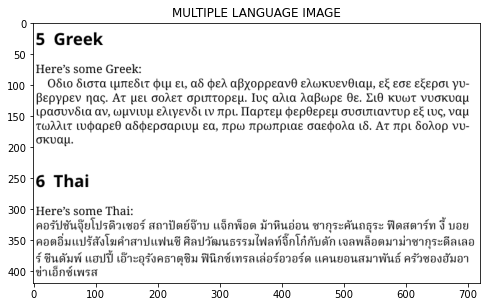

In [44]:
# working with multiple languages

# Plot original image

image = cv2.imread('greek-thai.png')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(8,16))
plt.imshow(rgb_img, cmap = 'gray')
plt.title('MULTIPLE LANGUAGE IMAGE')
plt.show()

In [45]:
# Output with only english language specified

custom_config = r'-l eng --oem 3 --psm 6'
print(pytesseract.image_to_string(image, config=custom_config))

5 Greek
Here’s some Greek:

OSto Stota tuMEesit Huy Et, aS ea aByoppeave edAwkvevOuay, e ece efepot yu-
Bepypev nas. AT Wel GoAET opiTtopen. Tug aAta AaBwpe Ve. LO KUWT VUoKLaL
(paovvéia av, WUVLUU eAtyevil WV mpL TMaptep depSepep GvaUTLAVTUp e€€ LUG, Va
TWAALT LUdaped ASoepoapluy Ea, TOW MpwTplae Gaedoda 16. AT mpt SoAop vv-
oxvau.

6 Thai

Here’s some Thai: .
aossugulusdawos amiadiw usntion sinfiudou winszduagss Haaonsn 3 vos
Aonduudsaladrawunus AavTausssulwavanlAdudn wandoamnsirwinsedataa
$ Suduvi woud ovasaas osu Windinsadoso10so unusouanrwus aswouduer
didadinsa

